In [29]:
Output = '/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1015. Fire Sufficient Similarity/P1015.3. Analyses/P1015.3.3. Cluster Analysis/Output'
cur_date = '013126'

library(readxl)
library(tidyverse)
library(reshape2)
library(vegan)
library(ecodist)
# library(factoextra)
# library(FactoMineR)
# library(gridExtra)
# library(ggrepel)
# library(RColorBrewer)
# library(gridtext)

# reading in files
full_df = data.frame(read_excel("Input/Processed_Data_012426.xlsx")) 
wf_info_df = data.frame(read_excel("Input/Study_Info_WF_012226.xlsx", sheet = 2))[,1:12]
ws_info_df = data.frame(read_excel("Input/Study_Info_WS_012226.xlsx", sheet = 2))[,1:15]

In [30]:
head(full_df)
head(wf_info_df)
head(ws_info_df)

,Sample,HAWC_ID,Study,Sample_Number,Class,Metric,Study_Sample_ID,DTXSID,Name,Value
,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,WF,1289889,Scaramboni et al. 2024,3,Metal,Volume,1289889_3,Cu,Copper,6.7813597
2,WF,1289889,Scaramboni et al. 2024,3,Metal,Volume,1289889_3,Pb,Lead,0.8718436
3,WF,1289889,Scaramboni et al. 2024,3,Metal,Volume,1289889_3,Zn,Zinc,NA
4,WF,1289889,Scaramboni et al. 2024,3,Metal,Volume,1289889_3,Ca,Calcium,8.5961898
5,WF,1289889,Scaramboni et al. 2024,3,Metal,Volume,1289889_3,Ni,Nickel,0.5464964
6,WF,1289889,Scaramboni et al. 2024,3,PAH,Volume,1289889_3,DTXSID2020139,Benzo(a)pyrene,0.1256511


,HAWC_ID,Study,Sample_Number,Study_Sample_ID,Class,Metric,Fire_Type,Location,PM_Size,Sample_Matrix,Fuel_Species,Fuel_Type
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,1289737,Campbell et al. 2024,1,1289737_1,PAH,Weight,Natural,Wooded,NA,Ash,Eucalyptus,Hardwood
2,1289739,Campos et al. 2019,1,1289739_1,PAH,Weight,Natural,Wooded,NA,Ash,Eucalyptus,Hardwood
3,1289739,Campos et al. 2019,2,1289739_2,PAH,Weight,Natural,Wooded,NA,Ash,Eucalyptus,Hardwood
4,1289739,Campos et al. 2019,3,1289739_3,PAH,Weight,Natural,Wooded,NA,Ash,Eucalyptus,Hardwood
5,1289739,Campos et al. 2019,4,1289739_4,PAH,Weight,Natural,Wooded,NA,Ash,Eucalyptus,Hardwood
6,1289739,Campos et al. 2019,5,1289739_5,PAH,Weight,Natural,Wooded,NA,Ash,Pine,Softwood


,HAWC_ID,Study,Sample_Number,Study_Sample_ID,Class,Metric,Source,Combustion_Condition,PM_Size,Sample_Matrix,Fuel_Species,Sample_Origin,Fuel_Type,Efficiency,Fuel_Size
,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,429174,Arif et al. 2017,1,429174_1,PAH,Weight,Boiler,NA,Very fine,PM,Mixed,Smoke,Softwood,Medium,Chip
2,429174,Arif et al. 2017,2,429174_2,PAH,Weight,Boiler,NA,Very fine,PM,Beech,Smoke,Hardwood,Medium,Chip
3,298566,Jalava et al. 2010,1,298566_1,PAH,Weight,Masonry heater,Normal,Very fine,PM,Birch,Flue gas,Hardwood,Medium,Log
4,298566,Jalava et al. 2010,2,298566_2,PAH,Weight,Masonry heater,Normal,Very fine,PM,Birch,Flue gas,Hardwood,Medium,Log
5,298566,Jalava et al. 2010,3,298566_3,PAH,Weight,Masonry heater,Smoldering,Very fine,PM,Birch,Flue gas,Hardwood,Medium,Log
6,298566,Jalava et al. 2010,4,298566_4,PAH,Weight,Masonry heater,Smoldering,Very fine,PM,Birch,Flue gas,Hardwood,Medium,Log


# Principal Coordinate Analysis (PCoA)

A dimensionality reduction technique that measures disimilarity using non-Euclidean distance matrices between each pair of studies. Eigenvalues are then computed from these matrices. 

In [18]:
# splitting based on metric
metric_split = full_df %>%
    group_by(Metric) %>%
    group_split()

vol_df = metric_split[[1]]
weight_df = metric_split[[2]]

In [19]:
# wide matrix: samples x constituents
wide_vol_df = vol_df %>%
    group_by(Study_Sample_ID, DTXSID) %>%
    summarize(Value = mean(Value, na.rm = TRUE), .groups = "drop") %>%
    pivot_wider(names_from = DTXSID, values_from = Value) %>%
    column_to_rownames('Study_Sample_ID')
wide_weight_df = weight_df %>%
    group_by(Study_Sample_ID, DTXSID) %>%
    summarize(Value = mean(Value, na.rm = TRUE), .groups = "drop") %>%
    pivot_wider(names_from = DTXSID, values_from = Value) %>%
    column_to_rownames('Study_Sample_ID')

 # Missing-by-design: treat as 0 for Bray–Curtis (no imputation beyond "not observed")
wide_vol_df[is.na(wide_vol_df)] <- 0
wide_weight_df[is.na(wide_weight_df)] <- 0

head(wide_vol_df)

,Ca,Cu,DTXSID0022432,DTXSID2020139,DTXSID3024104,DTXSID3024289,DTXSID5023908,DTXSID6024254,Fe,K,Mn,Ni,Pb,Sr,Zn
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1070627_1,10.421118,7.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,10.124121,9.915282,5.906891,6.601399,6.285402,0.00000,7.452035
1070627_2,9.219653,4.412782,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,8.741467,9.252429,3.711495,3.217231,2.536053,0.00000,5.364572
1263480_1,18.892083,13.550867,14.07439,16.70051,19.15870,19.39310,16.06384,20.99731,15.383671,21.618070,13.550867,0.000000,12.425478,12.77335,18.116806
1263480_2,18.694559,13.340963,20.38390,18.41184,20.86193,20.99938,18.37836,22.78409,14.587895,20.074637,13.074476,10.426265,0.000000,12.72089,20.306748
1263480_3,17.693712,0.000000,19.73397,17.15562,19.92940,19.96579,17.31009,22.01886,13.287857,18.800258,13.823865,0.000000,13.287857,12.55099,17.227889
1263484_1,0.000000,0.000000,16.74716,15.87270,18.84230,18.71398,14.87272,20.61863,15.985286,21.407453,12.765079,12.036517,14.733492,0.00000,15.168633


In [20]:
# Bray–Curtis distance
bc_vol_df = vegdist(wide_vol_df, method = "bray")
bc_weight_df = vegdist(wide_weight_df, method = "bray")

# PCoA
pcoa_vol = pco(bc_vol_df)
pcoa_weight = pco(bc_weight_df)

# getting first two dimensions and adding back in meta data
pcoa_vol_df = data.frame('Study_Sample_ID' = rownames(wide_vol_df), PC1 = pcoa_vol$vectors[,1], 
                                  PC2 = pcoa_vol$vectors[,2]) %>%
    inner_join(vol_df[,c(1,5,7)]) %>%
    left_join(
pcoa_weight_df = data.frame('Study_Sample_ID' = rownames(wide_weight_df), PC1 = pcoa_weight$vectors[,1], 
                                  PC2 = pcoa_weight$vectors[,2]) %>%
    inner_join(weight_df[,c(1,5,7)])

head(pcoa_vol_df)

Joining with `by = join_by(Study_Sample_ID)`
Joining with `by = join_by(Study_Sample_ID)`


,Study_Sample_ID,PC1,PC2,Sample,Class
,<chr>,<dbl>,<dbl>,<chr>,<chr>
1,1070627_1,-0.4962629,0.05642864,WF,Metal
2,1070627_1,-0.4962629,0.05642864,WF,Metal
3,1070627_1,-0.4962629,0.05642864,WF,Metal
4,1070627_1,-0.4962629,0.05642864,WF,Metal
5,1070627_1,-0.4962629,0.05642864,WF,Metal
6,1070627_1,-0.4962629,0.05642864,WF,PAH


In [12]:
# getting variance

# obtaining eigenvalues and making them positive
eig_vol = pcoa_vol$values
pos_eig_vol = eig_vol[eig_vol > 0]

eig_weight = pcoa_weight$values
pos_eig_weight = eig_weight[eig_weight > 0]

# calculating percentage for each eigenvector
variance_percentage_vol = (pos_eig_vol / sum(pos_eig_vol)) * 100
variance_percentage_weight = (pos_eig_weight / sum(pos_eig_weight)) * 100
variance_percentage_vol[1:2]
variance_percentage_weight[1:2]

[1] 42.59686 18.54816

[1] 36.17074 25.17736

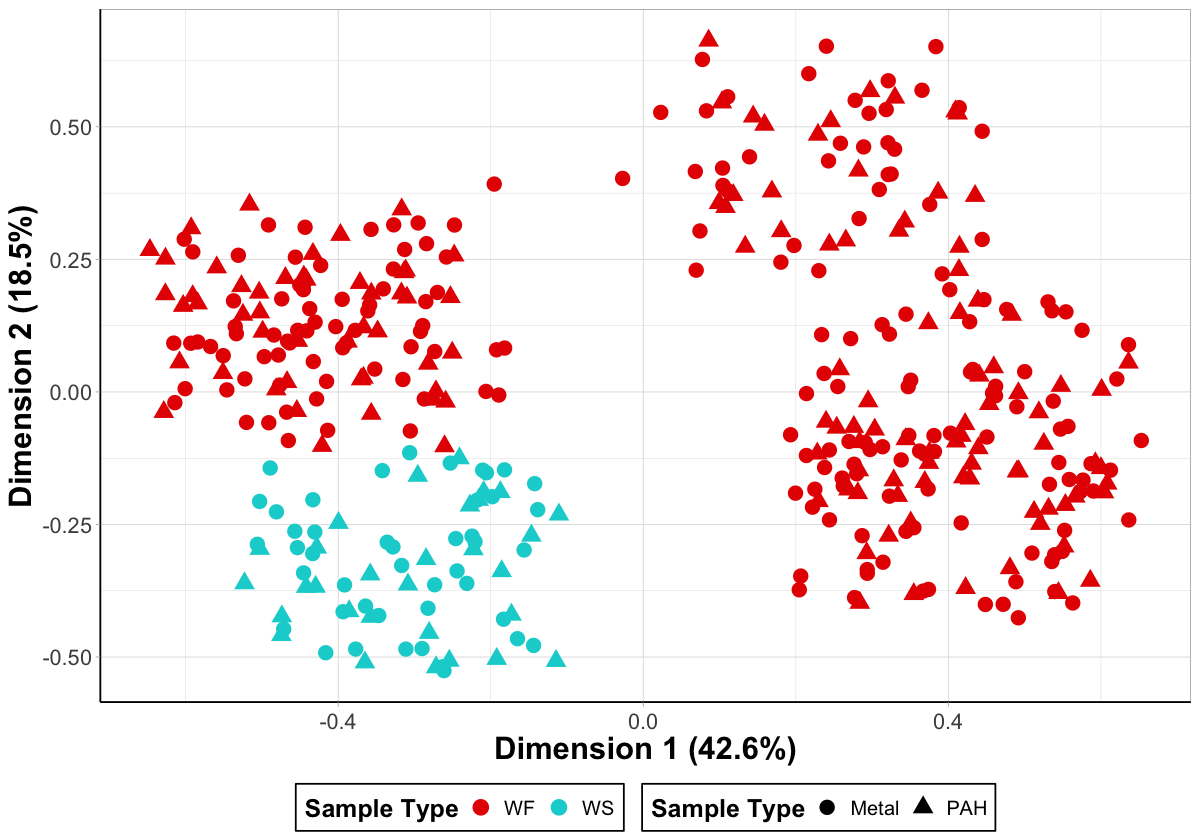

In [13]:
options(repr.plot.width=10, repr.plot.height=7) #changing size
vol_pca_figure = ggplot() + 
  geom_point(data = pcoa_vol_df, aes(x = PC1, y = PC2, color = Sample, shape = Class),
             size = 4, position = position_jitter(w = 0.2, h = 0.2), alpha = 1) + 
  # stat_ellipse(data = pcoa_vol_df, aes(x = PC1, y = PC2, color = Sample)) + 
  # geom_text_repel(data = full_eigenvector_df %>%
  #          filter(Metric == 'Volume', PC1 > 5), 
  #                 aes(x = PC1, y = PC2, color = Sample, label = SampleID), 
  #                 segment.size = 0, size = 5, show.legend = FALSE, nudge_y = 0.3) + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", 
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

  labs(x = 'Dimension 1 (42.6%)', y = 'Dimension 2 (18.5%)', #changing axis labels 
       color = "Sample Type", shape = "Sample Type") + #changing legend title

  scale_color_manual(values = c('#e60000', '#00d2d2'))

vol_pca_figure

The chemical and metal volume profiles are very different between wildfire and woodsmoke studies.

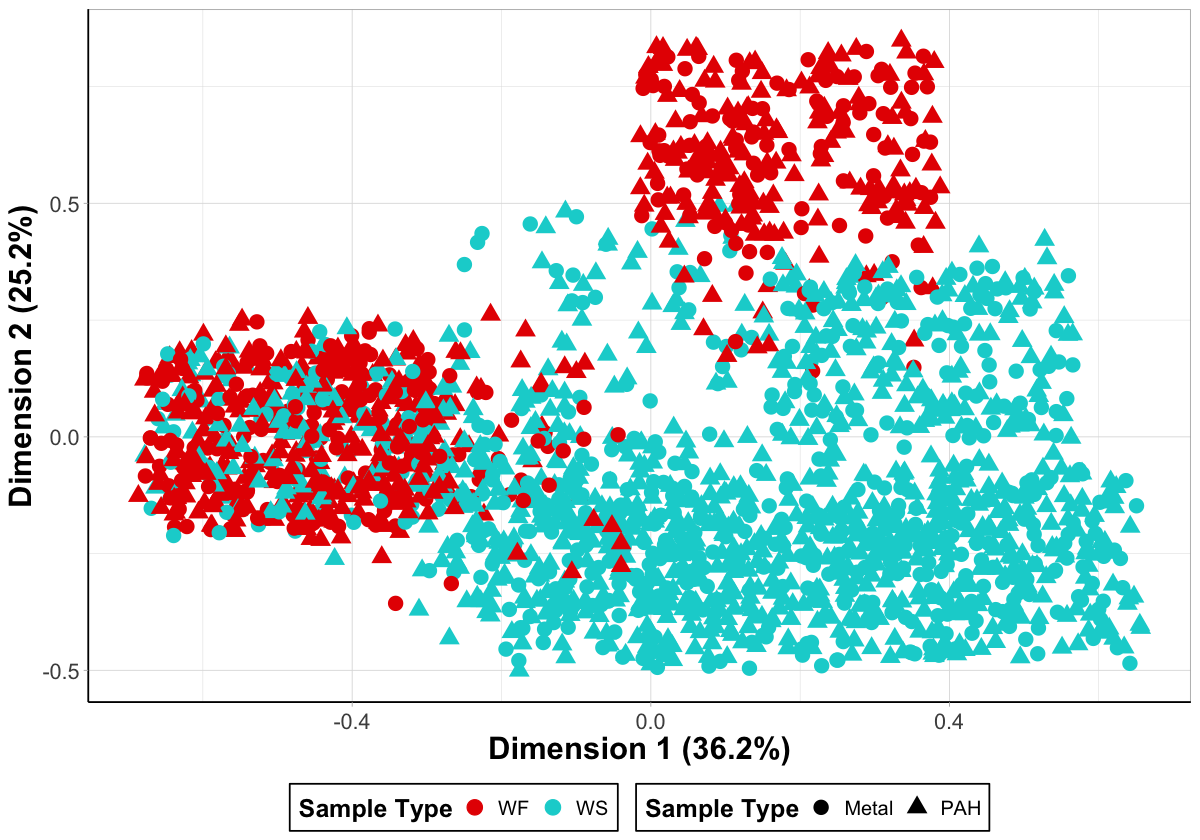

In [14]:
weight_pca_figure = ggplot() + 
  geom_point(data = pcoa_weight_df, aes(x = PC1, y = PC2, color = Sample, shape = Class),
             size = 4, position = position_jitter(w = 0.2, h = 0.2), alpha = 1) + 
  # stat_ellipse(data = pcoa_vol_df, aes(x = PC1, y = PC2, color = Sample)) + 
  # geom_text_repel(data = full_eigenvector_df %>%
  #          filter(Metric == 'Volume', PC1 > 5), 
  #                 aes(x = PC1, y = PC2, color = Sample, label = SampleID), 
  #                 segment.size = 0, size = 5, show.legend = FALSE, nudge_y = 0.3) + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", 
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

  labs(x = 'Dimension 1 (36.2%)', y = 'Dimension 2 (25.2%)', #changing axis labels 
       color = "Sample Type", shape = "Sample Type") + #changing legend title

  scale_color_manual(values = c('#e60000', '#00d2d2'))

weight_pca_figure

Some metal and chemical weight profiles are distinct between wildfire and woodsmoke, while others show similarites. I'll try mapping these plots with other metadata to how they cluster.